# Regression test case selection using quantum algorithms
Regression testing is an important part of the software development process in software engineering. It is a practice aimed at identifying any regressions, which are the emergence of new defects or issues in a software application following changes, enhancements, or updates made to the source code. In other words, regression testing focuses on how changes made to the software can affect the correct behavior of existing features. Regression testing is particularly important in agile software development environments, where changes are made frequently and rapidly. This practice helps ensure that the software remains stable and reliable as it evolves over time. To conduct regression testing, it is necessary to identify a set of test cases that cover the existing functionalities of the software; this problem is known as the "Test Case Selection" problem.
The problem of test case selection is a critical component of the regression testing process in the field of software engineering. This problem arises when choosing the test cases to be executed during a regression testing session, particularly when making changes to existing software.
The project presented in this notebook is aimed at solving the test case selection problem for regression testing using a quantum algorithm (which will be explained later). This problem will be treated as a binary variable optimization problem to obtain a subset of the original test suite of a program under observation, with the objectives of minimizing the test execution cost and maximizing the probability of detecting errors and test code coverage.

In [ ]:
#this cell contains all the imports needed by the pipeline
import json
from dwave.system import LeapHybridSampler
import dimod
from pathlib import Path
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
#this cell contains all variable definitions that will be useful throughout the entire project
sir_programs = ["flex","grep","gzip","sed"]
sir_programs_tests_number = {"flex":567,"grep":809,"gzip":214,"sed":360}
sir_programs_end_lines = {"flex":14192,"grep":13281,"gzip":6701,"sed":7118}
alpha = 0.5
tot_run = 30

## The pipeline dataset
To experiment the performance of the proposed solution by this work and to compare its results to those of state-of-the-art solutions, 4 public programs have been downloaded from the SIR website. SIR is a repository of software-related artifacts meant to support rigorous controlled experimentation with program analysis and software testing techniques, and education in controlled experimentation. 

### Chosen SIR Programs
The programs that will be used for experimentation have all been written in C and are:
- flex (a program that generates a lexical analysis program, based on regular expressions and C statement contained in one or more input files);
- grep (a useful program to search form matching patterns in a file);
- gzip (a program that substitute a file, generally text files or web pages, with their compressed version)
- sed (a powerful program for stream text editing).

### Needed information
The information needed by the quantum algorithm to work on every one of the 4 programs are:
- a fault matrix: it indicates whether a precise test case already found, during previous execution, a bug in the source code or not;
- execution cost: it indicates the execution cost of any test case of the suite;
- statement coverage: it indicates statement coverage information for every test case. 

All this information have been gathered through previous experimentation on the four programs mentioned above and written in files organized in the SIR_Programs folder. So, the first goal of the project will be gathering data from these files for computational purposes.

In [3]:
#let's make a function to read the fault matrices
#IMPORTANT: all the fault-matrix files must be renamed as "fault-matrix".txt and must be written using the same standard used by the files of this project (i-th line->e0e1e2e3..., where ej is 0 if the i-th test found a bug when launched on the j-th version)
def get_fault_list(program_name:str):
    """This function opens the fault-matrix file of a sir programs and make a list of binary values for each test case of that program to indicate whether a test case found or not a bug in at leat 1 of the available versions of the program"""
    #open the fault-matrix file of the desired SIR program
    program_file = open("SIR_Programs/"+program_name+"/fault-matrix.txt")
    lines = program_file.readlines()
    
    #we need a list which elements represent test cases, the i-th element is 1 if the i-th test case
    #discovered a fault in the past, 0 otherwise
    faults_test_by_test = list()
    
    i = 0
    for line in lines:
        if "1" in line:
            faults_test_by_test.append(1)
        else:
            faults_test_by_test.append(0)
        i += 1
    
    program_file.close()
    
    return faults_test_by_test

In [4]:
#the next function is able to research into the json coverage information file of each test case
#of each sir program to gather information about the single test cases costs and coverage
def cost_and_coverage_information_gathering(program_name:str):
    """The aim of this function is to obtain a dictionary that for each test case of a program indicates its cost, and a dictionary that, for each code line of the program to test, makes a list of all the test cases that run that line"""
    test_case_execution_cost = 0
    
    execution_cost_test_by_test = dict()
    executed_lines_test_by_test = dict()
    
    for test_case in range(sir_programs_tests_number[program_name]):
        #to open the correct file, we must remember that the folders and the json files are
        #numbered from 1 and not from 0
        if program_name == "gzip":
            json_name = "allfile"
        else:
            json_name = program_name
        test_case_json = open("SIR_Programs/"+program_name+"/json_"+program_name+"/t"+str(test_case+1)+"/"+json_name+str(test_case+1)+".gcov.json")
        
        #read the JSON object as a dictionary
        json_data = json.load(test_case_json)
        
        #for programs tested above more than one file, the initial row of a file will start from
        #the final row of the preceding file
        i = 0
        for file in json_data["files"]:
            line_count_start = i
            for line in file["lines"]:
                #if a line is executed, we want to remember FOR THAT LINE which are the tests
                #that executed it, and we want to increment the execution cost
                if line["unexecuted_block"] == False:
                    #the test suite exec cost = sum of the exec freq. of each executed basic block
                    #by each test case
                    #test_suite_execution_cost += line["count"]
                    test_case_execution_cost += line["count"]
                    
                    if (line_count_start + line["line_number"]) not in executed_lines_test_by_test:
                        executed_lines_test_by_test[line_count_start + line["line_number"]] = [test_case]
                    else:
                        executed_lines_test_by_test[line_count_start + line["line_number"]].append(test_case)
                    executed_lines_test_by_test[line_count_start + line["line_number"]].sort()
                i = line["line_number"]
        
        #saving the total amount of execution cost for this test case and resetting for the next
        execution_cost_test_by_test[test_case] = test_case_execution_cost
        test_case_execution_cost = 0
        
        test_case_json.close()
                        
    return execution_cost_test_by_test, executed_lines_test_by_test
                    

In [5]:
#we can now gain all the historical information about past fault detection 
faults_dictionary = {"flex": None, "grep": None, "gzip": None, "sed": None}

for sir_program in sir_programs:
    faults_dictionary[sir_program] = (get_fault_list(sir_program))

In [6]:
#we can now gain costs and coverage information

test_cases_costs = {"flex":None,"grep":None,"gzip":None,"sed":None}
coverage = {"flex":None,"grep":None,"gzip":None,"sed":None}

for sir_program in sir_programs:
    costs_and_coverage = cost_and_coverage_information_gathering(sir_program)
    test_cases_costs[sir_program] = costs_and_coverage[0]
    coverage[sir_program] = costs_and_coverage[1]

## Quantum Annealing
Quantum annealing is a quantum computing technique used by D-Wave Systems, and it's designed to solve combinatorial optimization problems.

Quantum annealing leverages the principles of quantum mechanics to search for optimal or approximate solutions to optimization problems. It relies on a gradual transition from an initial state to a final state through a process known as "annealing." During this transition, the system aims to minimize an objective function, which must be formulated in a way that can be tackled by the quantum annealer. This involves translating the problem into a mathematical form known as "Quadratic Unconstrained Binary Optimization" (QUBO), which is suitable for representation on a quantum computer.

D-Wave's quantum annealer uses quantum qubits to simultaneously explore different combinations of variable values, seeking the optimal solution. During the annealing process, transition probabilities between quantum states are adjusted to minimize the objective function. At the end of the annealing process, a solution is obtained, representing a potential assignment of values to the problem's variables while aiming to minimize the objective function.

## QUBO Problems
A Quadratic Unconstrained Binary Optimization (QUBO) problem is a type of mathematical problem where we seek to find the best combination of binary values (0 or 1) for a set of variables to minimize or maximize an objective function. In other words, we are looking for the optimal solution among all possible variable combinations that satisfy certain constraints and make the objective function as small as possible.

Weights for constraints (or penalty coefficients) are used in QUBO optimization problems to assign a numerical value to the constraints and influence the optimization process. These weights are important because they allow for managing the priority and relative importance of constraints within the optimization problem.

In [7]:
def create_adjvector_bqm(sir_program, alpha, P):
    """This function is the one that has to encode the QUBO problem that the D-Wave Hybrid Sampler will have to solve. The QUBO problem specifies the optimization to solve and a quadratic binary unconstrained problem"""
    qubo = dimod.AdjVectorBQM(dimod.BINARY)

    #linear coefficients, that are the diagonal of the matrix encoding the QUBO
    for i in range(sir_programs_tests_number[sir_program]):
        cost = alpha * test_cases_costs[sir_program][i] - (1 - alpha) * faults_dictionary[sir_program][i]
        qubo.set_linear(i, cost)

    #quadratic coefficient, that are the lower part of the QUBO matrix
    for k in coverage[sir_program].keys():
        test_cases = coverage[sir_program][k]
        for i in test_cases:
            for j in test_cases:
                if i < j:
                    qubo.set_linear(i,qubo.linear[i]-P)
                    qubo.set_linear(j,qubo.linear[j]-P)
                    try:
                        qubo.set_quadratic(i, j,qubo.quadratic[i,j] + 2 * P)
                    except:
                        qubo.set_quadratic(i, j, 2 * P)

    return qubo


In [8]:
def make_result_test_suite(sir_program,result_sample,index):
    """This function creates a .universe file that correspond to the solution test suite identified by the D-Wave machine"""
    #set the path containing the test suite file and its extension
    path = Path("SIR_Programs/" + sir_program)
    extension = ".universe"
    
    test_suite_file = None
    result_test_suite_file = None
    
    file_with_extension = next(path.glob(f"*{extension}"))
    if file_with_extension:
        test_suite_file = open(file_with_extension,"r")
        result_test_suite_file = open("SIR_Programs/" + sir_program + "/results" + str(index) + ".universe","w+")
    
    test_case = 0
    
    #here we want to write only the lines of the test cases identified by the solution
    for test_case_line in test_suite_file.readlines():
        if result_sample[test_case] == 1:
            result_test_suite_file.write(test_case_line)
        test_case += 1
    
    if file_with_extension:
        test_suite_file.close()
        result_test_suite_file.close()
            

In [9]:
penalties_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}

#in order to obtain a QUBO problem from a quadratic problem with constraints, we have to insert those constraints into the Hamiltonian to solve (which is the one encoded by the QUBO problem). When we insert constraint into the Hamiltonian, we have to specify also penalties
for sir_program in sir_programs:
    max = 0
    for i in range(sir_programs_tests_number[sir_program]):
        cost = alpha * test_cases_costs[sir_program][i] - (1 - alpha) * faults_dictionary[sir_program][i]
        if cost > max:
            max = cost
    penalties_dictionary[sir_program] = max + 1

In [10]:
qubos_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}

#make a dictionary that saves, for each program, the correspondent QUBO
for sir_program in sir_programs:
    qubos_dictionary[sir_program] = create_adjvector_bqm(sir_program,alpha,penalties_dictionary[sir_program])

## Evauation Metrics

### QPU Run Time
The QPU run time metric is an important measurement because it provides information about how long it takes for a quantum algorithm to run on the quantum hardware. It is a crucial factor in assessing the efficiency and performance of quantum computing systems. This metric can vary depending on the specific quantum hardware and the complexity of the quantum algorithm being executed. In this case, the sampler used is the D-Wave Hybrid Binary Quadratic Model (Version2).

### Hypervolume Metric
The hypervolume metric is a measure used in multi-objective optimization problems to evaluate the quality of solutions within the context of the Pareto front. It assesses the trade-offs between multiple conflicting objectives, and can identify solutions that offer better compromises between, in this case, test cases execution costs and faults discovery.

### Run Time Confidence Interval
The quantum run time confidence interval is a statistical range that quantifies the uncertainty in the execution time of a quantum computing program or algorithm. It provides a measure of the variability and reliability of the quantum computation's execution time. When dealing with quantum computers, there can be inherent variability in the execution times of quantum algorithms due to factors such as hardware fluctuations, noise, and the specific quantum computer architecture used. As a result, it's essential to estimate the confidence interval to understand the range of expected execution times.

In [11]:
def get_solution_cost(solution_number,solutions_dictionary_list,sir_program):
    """This function returns the total cost (in terms of execution cost) of a single solution given by the D-Wave machine"""
    solution_cost = 0
    try:
        for test_case, var_x in solutions_dictionary_list[solution_number].items():
            solution_cost += test_cases_costs[sir_program][test_case] * var_x
    except:
        #index out of range
        return 0
    return solution_cost

def get_total_fault_coverage(solution_numer,solutions_dictionary_list,sir_program):
    """This function returns the percentage of faults covered by a single solution given by the D-Wave machine"""
    total_faults = 0
    total_solution_faults = 0
    for fault_value in faults_dictionary[sir_program]:
        total_faults += fault_value
    for test_case, var_x in solutions_dictionary_list[solution_numer].items():
        if var_x:
            total_solution_faults += faults_dictionary[sir_program][test_case]
    return total_solution_faults/total_faults

In [12]:
sampler = LeapHybridSampler(token="API_KEY")

responses_dictionary = {"flex":[],"grep":[],"gzip":[],"sed":[]}
run_times_dictionary = {"flex":[],"grep":[],"gzip":[],"sed":[]}
I_CE_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}

I_CE_points = {"flex":[],"grep":[],"gzip":[],"sed":[]}

#I want to run the sampler 30 times to obtain different results for each sir program
for sir_program in sir_programs:
    response = None
    for _ in range(tot_run):
        #for each iteration get the result
        response = sampler.sample_qubo(qubos_dictionary[sir_program].to_numpy_matrix())
        sample_dictionary = {i: response.samples()[0][i] for i in range(len(response.samples()[0]))}
        responses_dictionary[sir_program].append(sample_dictionary)
        run_times_dictionary[sir_program].append(response.info["run_time"])
    #compute I_CE and save the I_CE points to make the final plots
    I_H = 0
    for solution in range(len(responses_dictionary[sir_program])):
        if solution == 0:
            solution_cost = get_solution_cost(solution,responses_dictionary[sir_program],sir_program)
            I_H += solution_cost
            total_solution_faults = 0
            for test_case, var_x in responses_dictionary[sir_program][solution].items():
                if var_x:
                    total_solution_faults += faults_dictionary[sir_program][test_case]
            I_CE_points[sir_program].append((solution_cost,total_solution_faults))
        else:
            solution_cost = get_solution_cost(solution,responses_dictionary[sir_program],sir_program)
            I_H += (get_solution_cost(solution+1,responses_dictionary[sir_program],sir_program)-solution_cost)*(1-get_total_fault_coverage(solution,responses_dictionary[sir_program],sir_program))
            total_solution_faults = 0
            for test_case, var_x in responses_dictionary[sir_program][solution].items():
                if var_x:
                    total_solution_faults += faults_dictionary[sir_program][test_case]
            I_CE_points[sir_program].append((solution_cost,total_solution_faults))
    if I_H<0: I_H *= -1
    I_CE_dictionary[sir_program] = I_H/get_solution_cost(len(responses_dictionary[sir_program])-1,responses_dictionary[sir_program],sir_program)
    #print the time iformation of the last run of the sir program
    run_time = response.info["run_time"]/1000000
    
    #Show the results
    print("INFORMATION FOR " + sir_program + ":")
    print("I_CE: " + str(I_CE_dictionary[sir_program]))
    print("TOTAL TIME: ", run_time, "seconds\n")

C:\Users\anton\AppData\Local\Temp\ipykernel_15192\1670916097.py:23: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  response = sampler.sample_qubo(qubos_dictionary[sir_program].to_numpy_matrix())


INFORMATION FOR flex:
I_CE: 1.2233361073582396
TOTAL TIME:  2.991724 seconds

INFORMATION FOR grep:
I_CE: 0.5197864952963451
TOTAL TIME:  2.992273 seconds

INFORMATION FOR gzip:
I_CE: 0.5195217755961453
TOTAL TIME:  2.986435 seconds

INFORMATION FOR sed:
I_CE: 0.5259592562813199
TOTAL TIME:  2.988043 seconds


In [13]:
def bootstrap_confidence_interval(data, num_samples, alpha=0.95):
    """This function determines the statistical range within we would expect the mean value of execution times to fall; it relies on the bootstrapping strategy, which allows the calculation of the confidence interval by repeatedly sampling (with replacement) from the existing data to obtain an estimate of the confidence interval."""
    sample_means = []
    for _ in range(num_samples):
        bootstrap_sample = [random.choice(data) for _ in range(len(data))]
        sample_mean = np.mean(bootstrap_sample)
        sample_means.append(sample_mean)
    
    lower_percentile = (1 - alpha) / 2 * 100
    upper_percentile = (alpha + (1 - alpha) / 2) * 100
    lower_bound = np.percentile(sample_means, lower_percentile)
    upper_bound = np.percentile(sample_means, upper_percentile)
    
    return lower_bound, upper_bound

In [23]:
confidence_interval_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}
num_bootstrap_samples = 1000  #number of bootstrap samples
alpha = 0.95  #confidence level

#apply the bootstrapping for each sir program
for sir_program in sir_programs:
    run_times = run_times_dictionary[sir_program]
    lower_bound, upper_bound = bootstrap_confidence_interval(run_times, num_bootstrap_samples, alpha)
    confidence_interval_dictionary[sir_program] = (lower_bound, upper_bound)

#show for each sir program the run time confidence interval
for sir_program in confidence_interval_dictionary.keys():
    print(f"Intervallo di confidenza per {sir_program}: ({confidence_interval_dictionary[sir_program][0]/1000000:.4f}, {confidence_interval_dictionary[sir_program][1]/1000000:.4f})")

Intervallo di confidenza per flex: (2.9937, 2.9966)
Intervallo di confidenza per grep: (2.9939, 2.9965)
Intervallo di confidenza per gzip: (2.9908, 2.9937)
Intervallo di confidenza per sed: (2.9890, 2.9924)


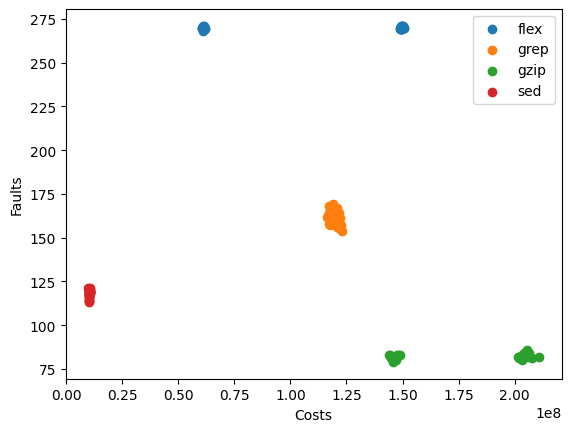

In [24]:
#draw the plot for all the solutions together
for sir_program in sir_programs:
    x,y = zip(*I_CE_points[sir_program])
    plt.scatter(x, y, label=sir_program)
    plt.xlabel('Costs')
    plt.ylabel('Faults')
    plt.legend()

PLOT JUST FOR: flex


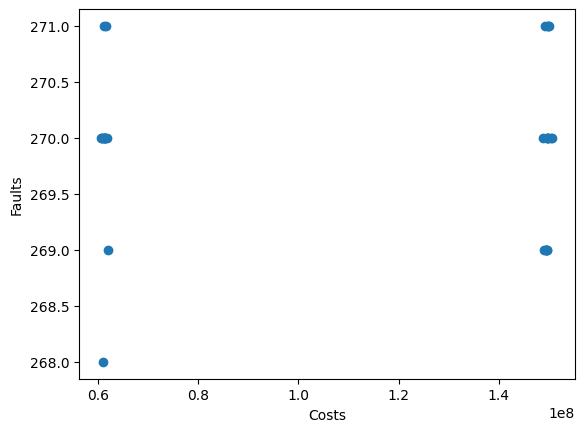

PLOT JUST FOR: grep


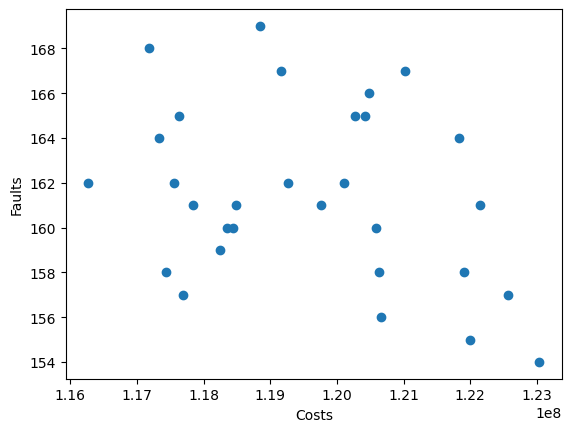

PLOT JUST FOR: gzip


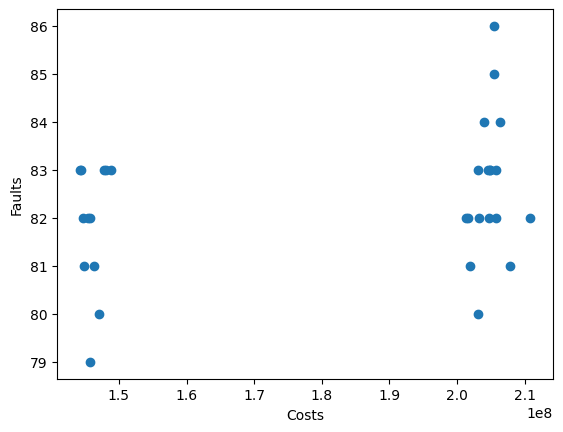

PLOT JUST FOR: sed


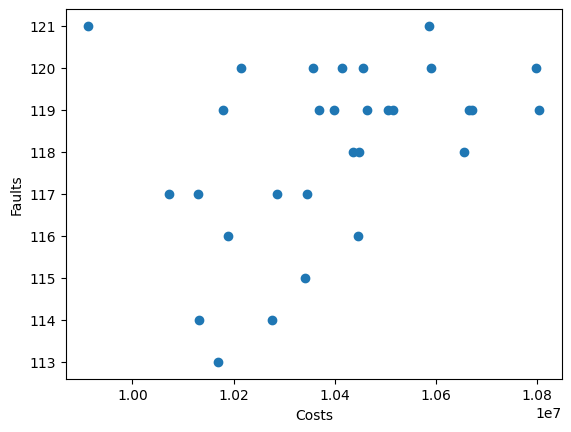

In [25]:
#draw the plot for all the solutions all together
for sir_program in sir_programs:
    x,y = zip(*I_CE_points[sir_program])
    print("PLOT JUST FOR: " + sir_program)
    plt.scatter(x, y)
    plt.xlabel('Costs')
    plt.ylabel('Faults')
    plt.show()